In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import numpy as np

In [3]:
import scanpy.external as sce
import scvi
from scvi.model import CondSCVI, DestVI
from scvi.external import RNAStereoscope, SpatialStereoscope

Global seed set to 0


In [4]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80, facecolor='white', frameon=True, figsize=(5, 5))

-----
anndata     0.8.0
scanpy      1.9.1
-----
PIL                         9.1.1
absl                        NA
anyio                       NA
attr                        21.2.0
babel                       2.9.1
backcall                    0.2.0
botocore                    1.23.24
certifi                     2022.06.15
cffi                        1.15.0
charset_normalizer          2.0.7
chex                        0.1.3
colorama                    0.4.5
cycler                      0.10.0
cython_runtime              NA
dateutil                    2.8.2
debugpy                     1.5.0
decorator                   5.1.1
defusedxml                  0.7.1
deprecate                   0.3.1
docrep                      0.3.2
entrypoints                 0.3
etils                       0.6.0
fastjsonschema              NA
flatbuffers                 2.0
flax                        0.5.2
fsspec                      2022.5.0
google                      NA
h5py                        3.7.0
idna  

In [8]:
# t1l_day7_slideseq = sc.read_10x_mtx(path="/fs/cbsuvlaminck2/workdir/dwm269/totalRNA/data/STARsolo/GRCm39_GENCODEM28_SlideSeq/Heart_Control/STAR/Solo.out/Gene/raw/")
t1l_day7_slideseq = sc.read_10x_mtx(path="/workdir/mm2937/MouseInfection/slideseq_fastqs/counts/Heart_ControlSolo.out/Gene/raw/")
# t1l_day7_slideseq.var_names = pd.read_csv("/fs/cbsuvlaminck2/workdir/dwm269/totalRNA/data/STARsolo/GRCm39_GENCODEM28_SlideSeq/Heart_Control/kb_standard/counts_unfiltered/output.genes.txt", delimiter="\t", header=None)[0]
# t1l_day7_slideseq.obs_names = pd.read_csv("/fs/cbsuvlaminck2/workdir/dwm269/totalRNA/data/STARsolo/GRCm39_GENCODEM28_SlideSeq/Heart_Control/kb_standard/counts_unfiltered/output.barcodes.txt", delimiter="\t", header=None)[0]
print(t1l_day7_slideseq.shape)

--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.


(173976075, 54848)


In [10]:
sc.pp.filter_cells(t1l_day7_slideseq, min_counts=1)
print(t1l_day7_slideseq.shape)

filtered out 171539466 cells that have less than 1 counts


(2436609, 54848)


In [11]:
# t1l_day7_slideseq.write_h5ad("./../t1l_day7_slideseq_mm.h5ad")

... storing 'feature_types' as categorical


In [ ]:
# t1l_day7_slideseq = sc.read_h5ad("./../t1l_day7_slideseq.h5ad")

In [12]:
t1l_day7_slideseq.obs_names = [(''.join(x.split("_"))) for x in t1l_day7_slideseq.obs_names]
print(t1l_day7_slideseq.shape)

(2436609, 54848)


In [13]:
barcodes = pd.read_csv("/fs/cbsuvlaminck2/workdir/dwm269/totalRNA/spTotal/resources/slideseq_bc_maps/A0004_043_BeadBarcodes.txt", delimiter="\t", names= ["barcode", "x", "y"])
barcodes[["x", "y"]].to_numpy()
barcodes.index = barcodes["barcode"]
print(barcodes.shape)

(77349, 3)


In [14]:
shared_barcodes = list(set(t1l_day7_slideseq.obs_names).intersection(set(barcodes["barcode"])))
t1l_day7_slideseq = t1l_day7_slideseq[shared_barcodes]
barcodes = barcodes.reindex(t1l_day7_slideseq.obs_names)
t1l_day7_slideseq.obs = t1l_day7_slideseq.obs.join(barcodes)
t1l_day7_slideseq.obsm["spatial"] = barcodes[["x", "y"]].to_numpy()

/home/mm2937/miniconda3/envs/python385-mouseinfection/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)


In [15]:
# t1l_day7_slideseq.write_h5ad("./../t1l_day7_slideseq_mm_with_image.h5ad")

In [128]:
t1l_day7_slideseq = sc.read_h5ad("./../t1l_day7_slideseq_mm_with_image.h5ad")

In [130]:
reoviral_genes = [name for name in t1l_day7_slideseq.var_names if name.startswith('Reo')]
print(reoviral_genes)
viral_expression = t1l_day7_slideseq[:,reoviral_genes].to_df()
viral_expression.columns = [x.split("_")[1] for x in viral_expression.columns]
reoviral_genes_indicator = np.in1d(t1l_day7_slideseq.var_names, reoviral_genes)
t1l_day7_slideseq = t1l_day7_slideseq[:, ~reoviral_genes_indicator]
t1l_day7_slideseq.var_names = [name.split("_")[1] for name in t1l_day7_slideseq.var_names]
t1l_day7_slideseq.obs = t1l_day7_slideseq.obs.join(viral_expression.astype(int))
print(t1l_day7_slideseq.shape)

['ReoT1L_T1LReoS1', 'ReoT1L_T1LReoS2', 'ReoT1L_T1LReoS3', 'ReoT1L_T1LReoS4', 'ReoT1L_T1LReoM1', 'ReoT1L_T1LReoM2', 'ReoT1L_T1LReoM3', 'ReoT1L_T1LReoL1', 'ReoT1L_T1LReoL2', 'ReoT1L_T1LReoL3']
(51054, 54838)


In [131]:
t1l_day7_slideseq.obs_names_make_unique()
t1l_day7_slideseq.var_names_make_unique()

t1l_day7_slideseq.var['mt'] = t1l_day7_slideseq.var_names.str.startswith('mt-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(t1l_day7_slideseq, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
t1l_day7_slideseq.obs['total_viral'] = viral_expression.sum(axis=1).astype(int)
t1l_day7_slideseq.obs['pct_viral'] = ((t1l_day7_slideseq.obs['total_viral']) / (t1l_day7_slideseq.obs['total_viral'] + t1l_day7_slideseq.obs['total_counts']))

In [132]:
sc.pp.filter_cells(t1l_day7_slideseq, min_counts=50)
sc.pp.filter_genes(t1l_day7_slideseq, min_counts=10)

filtered out 10654 cells that have less than 50 counts
filtered out 40693 genes that are detected in less than 10 counts


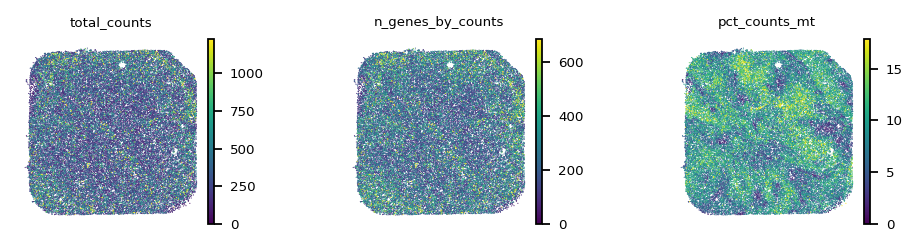

In [218]:
sc.settings.set_figure_params(dpi_save= 400, fontsize=6, figsize=(1.5,1.5), facecolor='white', frameon=False, transparent=True, format="pdf")
sc.pl.spatial(
        t1l_day7_slideseq,
        color= ["total_counts", "n_genes_by_counts", "pct_counts_mt"],
        spot_size=30, vmin=0, vmax='p99.2', save="slideseq_qc_spatial")
sc.settings.set_figure_params(dpi=80, facecolor='white', frameon=True, figsize=(5, 5))

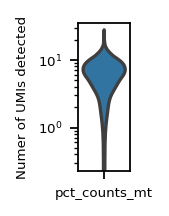

In [221]:
# #  ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
sc.settings.set_figure_params(dpi=80, dpi_save= 300, fontsize=6, frameon=False, figsize=(2,2), transparent=True, vector_friendly = False, format="pdf")
fig, ax = plt.subplots(figsize = (0.9,1.3))
plt.rc('font', size=6)
plt.grid(False)
sc.pl.violin(t1l_day7_slideseq, ['pct_counts_mt'],
             stripplot=False, multi_panel=False, scale="area" , rotation=0, log = True, show=False, ax =ax)
plt.ylabel("Numer of UMIs detected")
plt.tight_layout()
plt.savefig("./figures/violin_slideseq_qc3.pdf")
sc.settings.set_figure_params(dpi=80, facecolor='white', frameon=True, figsize=(5, 5))

In [139]:
t1l_day7_slideseq.write_h5ad("./../t1l_day7_slideseq_mm_with_image_filtered.h5ad")

In [86]:
t1l_day7_slideseq = sc.read_h5ad("./../t1l_day7_slideseq_mm_with_image_filtered.h5ad")
t1l_day7_slideseq

AnnData object with n_obs × n_vars = 40400 × 14145
    obs: 'n_counts', 'barcode', 'x', 'y', 'T1LReoS1', 'T1LReoS2', 'T1LReoS3', 'T1LReoS4', 'T1LReoM1', 'T1LReoM2', 'T1LReoM3', 'T1LReoL1', 'T1LReoL2', 'T1LReoL3', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_viral', 'pct_viral'
    var: 'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_counts'
    obsm: 'spatial'

In [87]:
s_genes = list(pd.read_csv("./../s.genes.txt")["x"])
g2m_genes = list(pd.read_csv("./../g2m.genes.txt")["x"])
print(s_genes)
print(g2m_genes)

['Mcm4', 'Exo1', 'Slbp', 'Gmnn', 'Cdc45', 'Msh2', 'Mcm6', 'Rrm2', 'Pold3', 'Blm', 'Ubr7', 'Mcm5', 'Clspn', 'Hells', 'Nasp', 'Rpa2', 'Rad51ap1', 'Tyms', 'Rrm1', 'Rfc2', 'Prim1', 'Brip1', 'Usp1', 'Ung', 'Pola1', 'Mcm2', 'Fen1', 'Tipin', 'Pcna', 'Cdca7', 'Uhrf1', 'Casp8ap2', 'Cdc6', 'Dscc1', 'Wdr76', 'E2f8', 'Dtl', 'Ccne2', 'Atad2', 'Gins2', 'Chaf1b', 'Pcna-ps2']
['Nuf2', 'Psrc1', 'Ncapd2', 'Ccnb2', 'Smc4', 'Lbr', 'Tacc3', 'Cenpa', 'Kif23', 'Cdca2', 'Anp32e', 'G2e3', 'Cdca3', 'Anln', 'Cenpe', 'Gas2l3', 'Tubb4b', 'Cenpf', 'Dlgap5', 'Hjurp', 'Cks1brt', 'Gtse1', 'Bub1', 'Birc5', 'Ube2c', 'Rangap1', 'Hmmr', 'Ect2', 'Tpx2', 'Ckap5', 'Cbx5', 'Nek2', 'Ttk', 'Cdca8', 'Nusap1', 'Ctcf', 'Cdc20', 'Cks2', 'Mki67', 'Tmpo', 'Ckap2l', 'Aurkb', 'Kif2c', 'Cdk1', 'Kif20b', 'Top2a', 'Aurka', 'Ckap2', 'Hmgb2', 'Cdc25c', 'Ndc80', 'Kif11']


normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:13)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


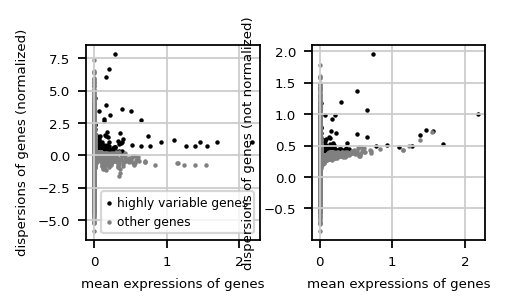

calculating cell cycle phase
computing score 'S_score'
    finished: added
    'S_score', score of gene set (adata.obs).
    708 total control genes are used. (0:00:00)
computing score 'G2M_score'


/home/mm2937/miniconda3/envs/python397/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):
/home/mm2937/miniconda3/envs/python397/lib/python3.9/site-packages/scanpy/tools/_score_genes.py:151: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  for cut in np.unique(obs_cut.loc[gene_list]):


    finished: added
    'G2M_score', score of gene set (adata.obs).
    793 total control genes are used. (0:00:00)
-->     'phase', cell cycle phase (adata.obs)
(40400, 1093)


In [88]:
sc.pp.normalize_total(t1l_day7_slideseq, inplace=True)
sc.pp.log1p(t1l_day7_slideseq)
sc.pp.highly_variable_genes(t1l_day7_slideseq, max_mean=3, min_disp=0.25)
sc.pl.highly_variable_genes(t1l_day7_slideseq)
sc.tl.score_genes_cell_cycle(t1l_day7_slideseq, s_genes=s_genes, g2m_genes=g2m_genes)
t1l_day7_slideseq.raw = t1l_day7_slideseq
t1l_day7_slideseq = t1l_day7_slideseq[:, t1l_day7_slideseq.var.highly_variable]
print(t1l_day7_slideseq.shape)

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


/home/mm2937/miniconda3/envs/python397/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:11)


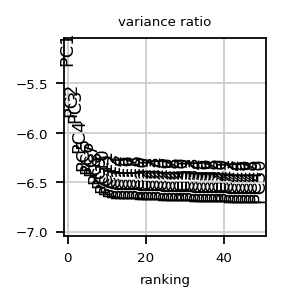

computing neighbors
    using 'X_pca' with n_pcs = 20
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:31)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:41)


In [89]:
sc.pp.scale(t1l_day7_slideseq, max_value=10)
sc.pp.pca(t1l_day7_slideseq, random_state= 0)
sc.pl.pca_variance_ratio(t1l_day7_slideseq, n_pcs = 50, log=True)
sc.pp.neighbors(t1l_day7_slideseq, n_pcs=20)
sc.tl.umap(t1l_day7_slideseq)

In [90]:
sc.tl.leiden(t1l_day7_slideseq, key_added="leiden_0.8", resolution = 0.8)
sc.tl.leiden(t1l_day7_slideseq, key_added="leiden_1.0", resolution = 1.0)

running Leiden clustering
    finished: found 8 clusters and added
    'leiden_0.8', the cluster labels (adata.obs, categorical) (0:00:21)
running Leiden clustering
    finished: found 10 clusters and added
    'leiden_1.0', the cluster labels (adata.obs, categorical) (0:00:16)


In [91]:
t1l_day7_slideseq

AnnData object with n_obs × n_vars = 40400 × 1093
    obs: 'n_counts', 'barcode', 'x', 'y', 'T1LReoS1', 'T1LReoS2', 'T1LReoS3', 'T1LReoS4', 'T1LReoM1', 'T1LReoM2', 'T1LReoM3', 'T1LReoL1', 'T1LReoL2', 'T1LReoL3', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_viral', 'pct_viral', 'S_score', 'G2M_score', 'phase', 'leiden_0.8', 'leiden_1.0'
    var: 'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden'
    obsm: 'spatial', 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

... storing 'phase' as categorical


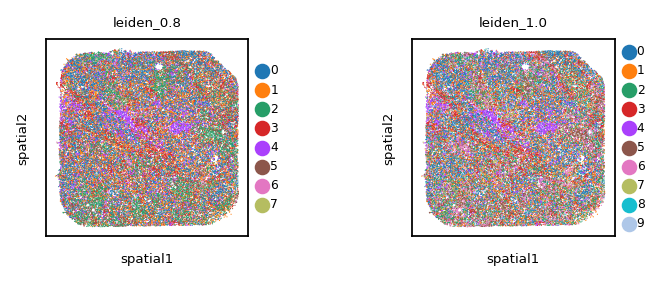

In [92]:
sc.pl.spatial(t1l_day7_slideseq, color=["leiden_0.8", "leiden_1.0"], spot_size=30, wspace=0.5)

... storing 'phase' as categorical


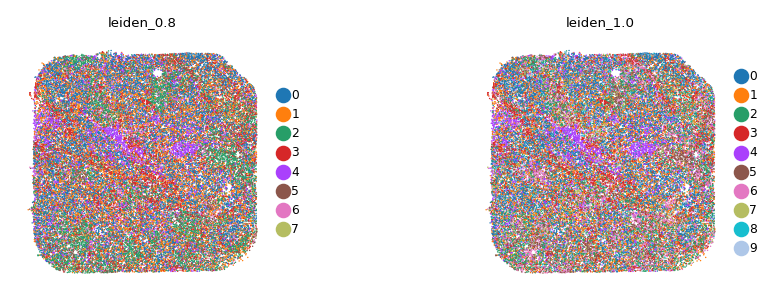

In [146]:
sc.pl.spatial(t1l_day7_slideseq, color=["leiden_0.8", "leiden_1.0"], spot_size=30, wspace=0.5)

    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_leiden_1.0']`


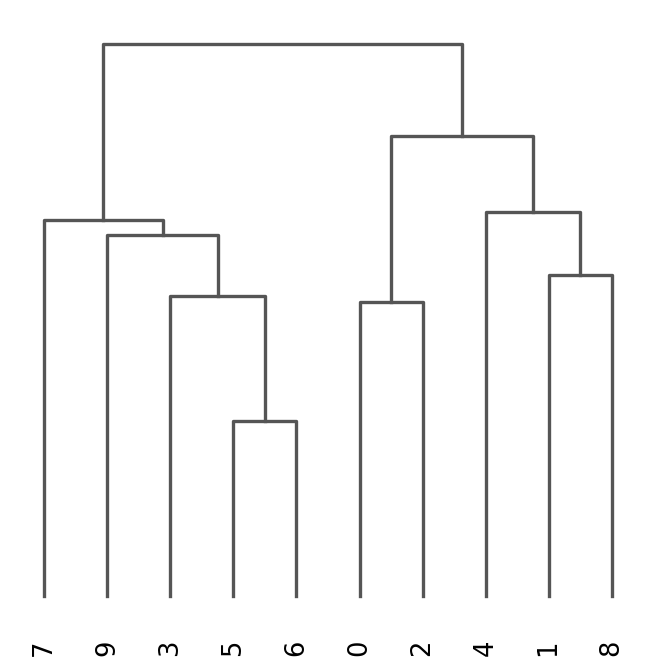

<AxesSubplot:>

In [150]:
sc.tl.dendrogram(t1l_day7_slideseq, groupby="leiden_1.0")
sc.pl.dendrogram(t1l_day7_slideseq, groupby="leiden_1.0")

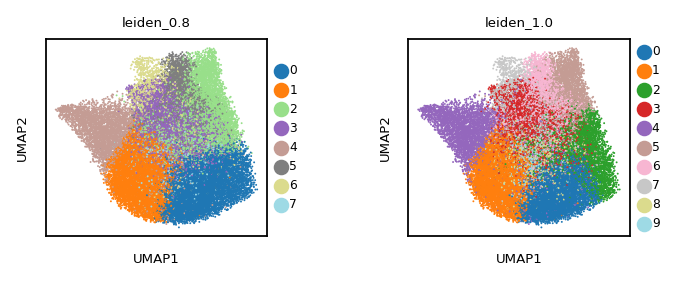

In [107]:
sc.pl.umap(t1l_day7_slideseq, color=["leiden_0.8", "leiden_1.0"], palette="tab20")

In [94]:
sc.tl.rank_genes_groups(t1l_day7_slideseq, 'leiden_1.0', method='wilcoxon', key_added='rank_genes_groups_leiden_1.0')

ranking genes
    finished: added to `.uns['rank_genes_groups_leiden_1.0']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:01:00)


In [95]:
pd.DataFrame(t1l_day7_slideseq.uns['rank_genes_groups_leiden_1.0']['names']).head(10)

0        1       2         3        4       5       6        7  \
0    Fabp3  mt-Rnr2  Ankrd1    Col3a1   Hbb-bs    Gzma    Actb   S100a9   
1       Mb   mt-Nd1  Malat1    Col1a2   Hba-a2    Actb    Ctss   S100a8   
2     Myl2  mt-Rnr1   Tnnt2      Saa3   Hba-a1  Tmsb4x  Tmsb4x   Gm5483   
3  mt-Rnr1     Myh6   Neat1     Sparc   Hbb-bt    Gzmb    Fth1    Slfn4   
4   mt-Nd1     Myl2  Gm4841       Mgp     Bpgm  Lgals1   Tgfbi     Actb   
5    Tnni3  Slc25a4    Nppa    Igfbp7    Fabp4    Ppia     Vim      B2m   
6     Myh6    Fabp3     Ttn  Serping1    Alas2    Rps6   Plac8    Stfa1   
7  Slc25a4     Myl3   Csrp3       Dcn    Isg15    Ccl5  Tyrobp    Isg15   
8  mt-Rnr2    Actc1     Clu        C3    Mkrn1  Tuba1b    Lyz2     Srgn   
9   mt-Nd4   Fgfbp3   Myom1     Fstl1  mt-Rnr2   Trbc2    Ly6a  Stfa2l1   

         8       9  
0     Naca   Fabp4  
1   Gm6863    Ly6a  
2  mt-Rnr2   Cxcl9  
3  mt-Cytb     Ubd  
4    Actc1  Ifitm3  
5     Myl3   Timp3  
6     Myl2   Gng11  
7   mt-Nd4    Rps6  
8  Slc25a4   Sparc  
9    Fabp3  Igfbp7

In [97]:
t1l_day7_slideseq.obs["celltypes_leiden_1.0"] = t1l_day7_slideseq.obs["leiden_1.0"]
celltypes = {'0': "Cardiomyocytes-1", 
                '1': "Cardiomyocytes-2", 
                '2': "Border-zone cardiomyocytes", 
                '5': "T cells",
                '3': "Fibroblasts",
                '6': "Dendritic cells",
                 '4': "Erythroblasts",
                '9': "Cxcl9-high endothelial cells",
                 '8': "Cardiomyocytes-2",
                 '7': "Neutrophils"}
t1l_day7_slideseq.obs["celltypes_leiden_1.0"] = t1l_day7_slideseq.obs["celltypes_leiden_1.0"].map(celltypes).astype("category")

    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_celltypes_leiden_1.0']`


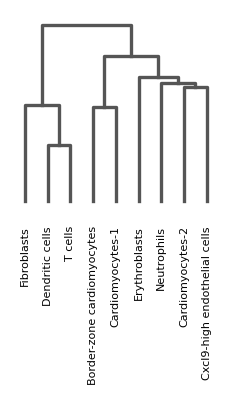

<AxesSubplot:>

In [98]:
sc.tl.dendrogram(t1l_day7_slideseq, groupby="celltypes_leiden_1.0")
sc.pl.dendrogram(t1l_day7_slideseq, groupby="celltypes_leiden_1.0")

In [99]:
sc.tl.rank_genes_groups(t1l_day7_slideseq, 'celltypes_leiden_1.0', method='wilcoxon', key_added='rank_genes_groups_celltypes_leiden_1.0')

ranking genes
    finished: added to `.uns['rank_genes_groups_celltypes_leiden_1.0']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:50)


In [100]:
result = t1l_day7_slideseq.uns['rank_genes_groups_celltypes_leiden_1.0']
groups = list(result['names'].dtype.names)
dge_results = pd.DataFrame(
    {group + '_' + key: result[key][group]
    for group in groups for key in ['names', 'logfoldchanges', 'pvals_adj']}).head(100)
dge_results.to_csv("./../csvs_github/DGE_slideseq_celltypes_leiden_1.0.csv")

In [101]:
import itertools
genes = list(itertools.chain(*pd.DataFrame(t1l_day7_slideseq.uns['rank_genes_groups_celltypes_leiden_1.0']['names']).head(5).values.tolist()))
print(genes)

['Ankrd1', 'Fabp3', 'mt-Rnr2', 'Fabp4', 'Actb', 'Hbb-bs', 'Col3a1', 'S100a9', 'Gzma', 'Malat1', 'Mb', 'mt-Nd1', 'Ly6a', 'Ctss', 'Hba-a2', 'Col1a2', 'S100a8', 'Actb', 'Tnnt2', 'Myl2', 'mt-Rnr1', 'Cxcl9', 'Tmsb4x', 'Hba-a1', 'Saa3', 'Gm5483', 'Tmsb4x', 'Neat1', 'mt-Rnr1', 'Myl2', 'Ubd', 'Fth1', 'Hbb-bt', 'Sparc', 'Slfn4', 'Gzmb', 'Gm4841', 'mt-Nd1', 'Myh6', 'Ifitm3', 'Tgfbi', 'Bpgm', 'Mgp', 'Actb', 'Lgals1']


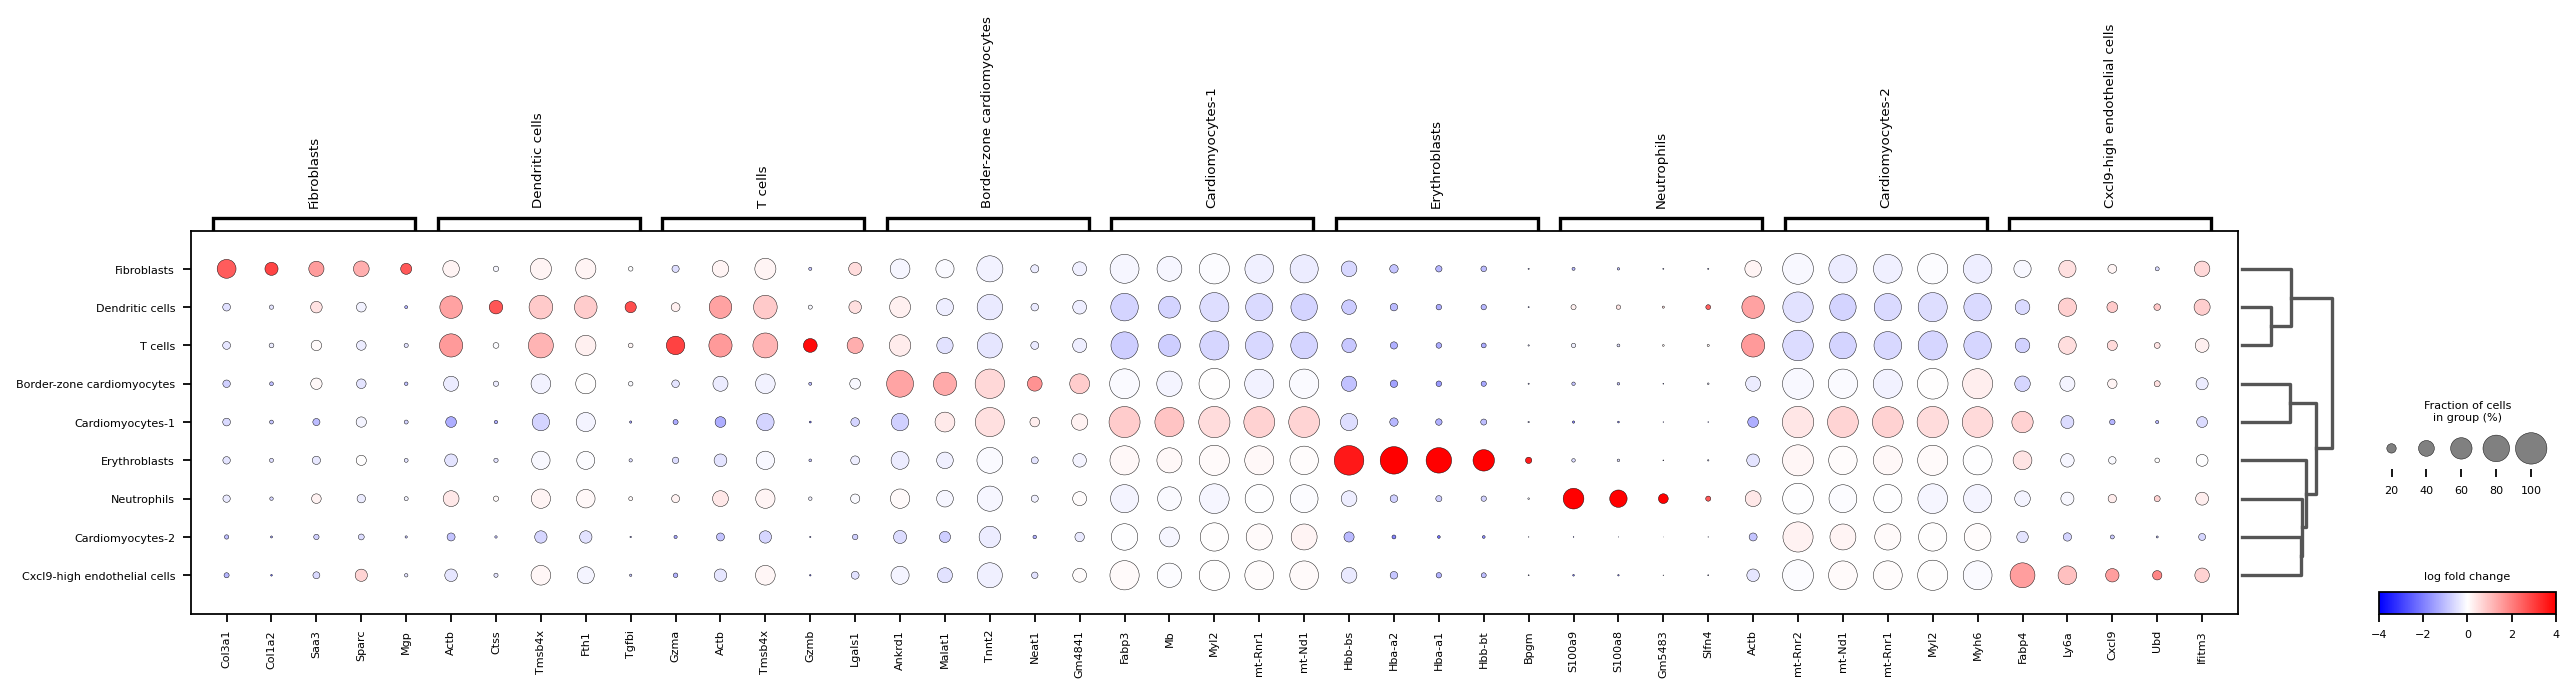

In [102]:
sc.settings.set_figure_params(dpi=80, dpi_save= 300, fontsize=6, frameon=True, figsize=(3, 3), vector_friendly = False, transparent=True, format="pdf")
sc.pl.rank_genes_groups_dotplot(t1l_day7_slideseq, key= "rank_genes_groups_celltypes_leiden_1.0", n_genes=5, values_to_plot="logfoldchanges", cmap='bwr', vmin = -4, vmax = +4, save="slideseq.pdf", )
sc.settings.set_figure_params(dpi=80, dpi_save= 300, fontsize=6, frameon=True, figsize=(3, 3), transparent=True, format="pdf")

In [103]:
t1l_day7_slideseq.obs["celltypes_leiden_1.0"] = t1l_day7_slideseq.obs["celltypes_leiden_1.0"].astype("category")
t1l_day7_slideseq.obs["celltypes_leiden_1.0"].cat.reorder_categories(
    new_categories = ["Cardiomyocytes-1", 
                 "Cardiomyocytes-2", 
                 "Border-zone cardiomyocytes", 
                 "T cells",
                 "Dendritic cells",
                 "Fibroblasts",
                 "Cxcl9-high endothelial cells",
                 "Neutrophils",
                 "Erythroblasts"], inplace = True)

/tmp/ipykernel_126362/982575672.py:2: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  t1l_day7_slideseq.obs["celltypes_leiden_1.0"].cat.reorder_categories(


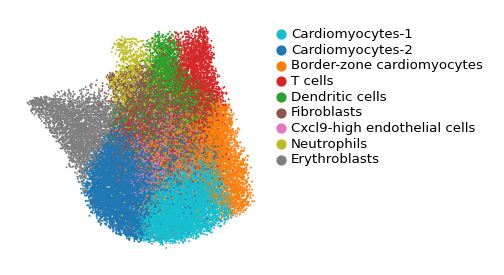

In [104]:
sc.settings.set_figure_params(dpi=80, dpi_save= 300, fontsize=6, facecolor='white', frameon=True, figsize=(1.6, 1.6), vector_friendly = False, transparent=True, format="pdf")
fig, ax = plt.subplots(figsize = (2.0, 2.0))
sc.pl.umap(t1l_day7_slideseq, color = ['celltypes_leiden_1.0'], legend_fontsize=6, frameon=False, title="", palette=['#17becf', 
 '#1f77b4',
 '#ff7f0e',
 '#d62728',
 '#2ca02c',
 '#8c564b',
 '#e377c2',
 '#bcbd22',
 '#7f7f7f'], show=False, ax = ax)
plt.legend(ncol=1, prop={'size': 6}, handletextpad=0.5, markerscale = 0.6, frameon = False, labelspacing = 0.2, bbox_to_anchor = (1.0,1.0))
# plt.tight_layout()
plt.savefig("figures/celltypes_slideseq_umap.pdf")

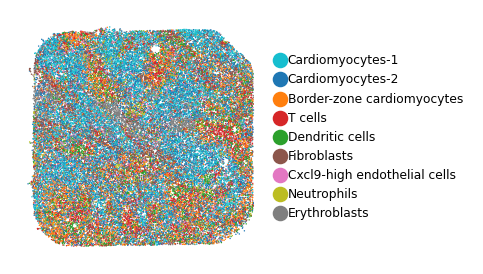

In [77]:
sc.settings.set_figure_params(dpi=80, dpi_save= 300, fontsize=6, facecolor='white', frameon=False, figsize=(2.0, 2.0), vector_friendly = False, transparent=True, format="pdf")
sc.pl.spatial(t1l_day7_slideseq, color=["celltypes_leiden_1.0"], spot_size=30, wspace=0.5, title="", palette=['#17becf', 
 '#1f77b4',
 '#ff7f0e',
 '#d62728',
 '#2ca02c',
 '#8c564b',
 '#e377c2',
 '#bcbd22',
 '#7f7f7f'], save="celltypes_slideseq_spatial.pdf")

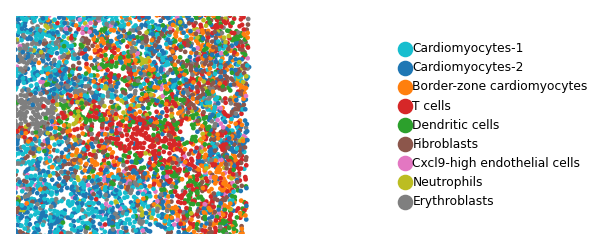

In [78]:
sc.settings.set_figure_params(dpi=80, dpi_save= 300, fontsize=6, facecolor='white', frameon=False, figsize=(3.0, 3.0), vector_friendly = False, transparent=True, format="pdf")
sc.pl.spatial(t1l_day7_slideseq, color=["celltypes_leiden_1.0"], spot_size=30, wspace=0.5, title="", palette=['#17becf', 
 '#1f77b4',
 '#ff7f0e',
 '#d62728',
 '#2ca02c',
 '#8c564b',
 '#e377c2',
 '#bcbd22',
 '#7f7f7f'], crop_coord = [4400,6800,1800,3200], save="celltypes_slideseq_spatial_crop.pdf")

/home/mm2937/miniconda3/envs/python397/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.
  values = values.replace(values.categories.difference(groups), np.nan)


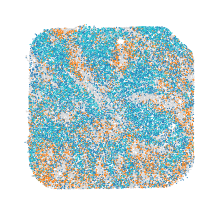

In [66]:
sc.settings.set_figure_params(dpi=80, dpi_save= 300, fontsize=6, facecolor='white', frameon=False, figsize=(1.5, 1.5), vector_friendly = False, transparent=True, format="pdf")
sc.pl.spatial(t1l_day7_slideseq, color=["celltypes_leiden_1.0"], groups=["Cardiomyocytes-1", 
                 "Cardiomyocytes-2", 
                 "Inflamed cardiomyocytes"], spot_size=30, wspace=0.5, title="", palette=['#17becf', 
 '#1f77b4',
 '#ff7f0e',
 '#d62728',
 '#2ca02c',
 '#8c564b',
 '#e377c2',
 '#bcbd22',
 '#7f7f7f'], legend_loc= "none", save="celltypes_slideseq_spatial_subset1.pdf")

/home/mm2937/miniconda3/envs/python397/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.
  values = values.replace(values.categories.difference(groups), np.nan)


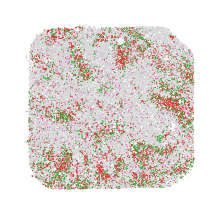

In [64]:
sc.settings.set_figure_params(dpi=80, dpi_save= 300, fontsize=6, facecolor='white', frameon=False, figsize=(1.5, 1.5), vector_friendly = False, transparent=True, format="pdf")
sc.pl.spatial(t1l_day7_slideseq, color=["celltypes_leiden_1.0"], groups=["Cxcl9-high inflamed\n endothelial cells", "Dendritic cells", "T cells"], spot_size=30, wspace=0.5, title="", palette=['#17becf', 
 '#1f77b4',
 '#ff7f0e',
 '#d62728',
 '#2ca02c',
 '#8c564b',
 '#e377c2',
 '#bcbd22',
 '#7f7f7f'], save="celltypes_slideseq_spatial_subset2.pdf", legend_loc="none")

/home/mm2937/miniconda3/envs/python397/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1171: FutureWarning: Categorical.replace is deprecated and will be removed in a future version. Use Series.replace directly instead.
  values = values.replace(values.categories.difference(groups), np.nan)


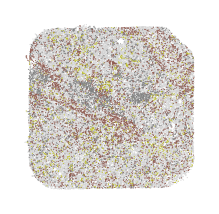

In [67]:
sc.settings.set_figure_params(dpi=80, dpi_save= 300, fontsize=6, facecolor='white', frameon=False, figsize=(1.5, 1.5), vector_friendly = False, transparent=True, format="pdf")
sc.pl.spatial(t1l_day7_slideseq, color=["celltypes_leiden_1.0"], groups=["Neutrophils", "Inflamed fibroblasts", "Erythroblasts"], spot_size=30, wspace=0.5, title="", palette=['#17becf', 
 '#1f77b4',
 '#ff7f0e',
 '#d62728',
 '#2ca02c',
 '#8c564b',
 '#e377c2',
 '#bcbd22',
 '#7f7f7f'], save="celltypes_slideseq_spatial_subset3.pdf", legend_loc="none")

In [105]:
t1l_day7_slideseq.write_h5ad("./../t1l_day7_slideseq_mm_with_image_filtered_processed.h5ad")